<a href="https://colab.research.google.com/github/YTW0415/Kaggle_Basketball/blob/main/Kaggle_basket_20230304.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Dataset 불러오기 - 태원's github 주소에서 불러오는거니 실제 수상 시 없애고 자기 깃허브 주소로 변경 바랍니다

In [1]:
!git clone https://github.com/YTW0415/Kaggle_Basketball.git

Cloning into 'Kaggle_Basketball'...
remote: Enumerating objects: 70, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 70 (delta 14), reused 37 (delta 3), pack-reused 0
Unpacking objects: 100% (70/70), 29.07 MiB | 4.74 MiB/s, done.
Updating files: 100% (39/39), done.


# Adapting the 2nd Place Solution of the 2021 NCAAW Competition

- Solution write-up is available here : https://www.kaggle.com/c/ncaaw-march-mania-2021/discussion/230705
- 2nd place code : https://www.kaggle.com/theoviel/2nd-place-ncaaw-2021?scriptVersionId=58780991
- It was adapted from this notebook : https://www.kaggle.com/theoviel/ncaa-starter-the-simpler-the-better 

**Changes :**
- Build one model for both Men and Women
- Update metric to MSE

In [2]:
import os
import re
import sklearn
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.metrics import *
from sklearn.linear_model import *
from sklearn.model_selection import *

pd.set_option('display.max_columns', None)

In [3]:
DATA_PATH = '/content/Kaggle_Basketball/march-machine-learning-mania-2023/'

for filename in sorted(os.listdir(DATA_PATH)):
    print(filename)

Cities.csv
Conferences.csv
MConferenceTourneyGames.csv
MGameCities.csv
MMasseyOrdinals.csv
MNCAATourneyCompactResults.csv
MNCAATourneyDetailedResults.csv
MNCAATourneySeedRoundSlots.csv
MNCAATourneySeeds.csv
MNCAATourneySlots.csv
MRegularSeasonCompactResults.csv
MRegularSeasonDetailedResults.csv
MSeasons.csv
MSecondaryTourneyCompactResults.csv
MSecondaryTourneyTeams.csv
MTeamCoaches.csv
MTeamConferences.csv
MTeamSpellings.csv
MTeams.csv
SampleSubmission2023.csv
WGameCities.csv
WNCAATourneyCompactResults.csv
WNCAATourneyDetailedResults.csv
WNCAATourneySeeds.csv
WNCAATourneySlots.csv
WRegularSeasonCompactResults.csv
WRegularSeasonDetailedResults.csv
WSeasons.csv
WTeamConferences.csv
WTeamSpellings.csv
WTeams.csv
kenpom0823.csv


# Data preparation

## Seeds
> This file identifies the seeds for all teams in each NCAA® tournament, for all seasons of historical data. Thus, there are between 64-68 rows for each year, depending on whether there were any play-in games and how many there were. In recent years the structure has settled at 68 total teams, with four "play-in" games leading to the final field of 64 teams entering Round 1 on Thursday of the first week (by definition, that is DayNum=136 each season). We will not know the seeds of the respective tournament teams, or even exactly which 68 teams it will be, until Selection Sunday on March 15, 2020 (DayNum=132).

> The seed is a 3/4-character :
- First character : Region (W, X, Y, or Z)
- Next two digits : Seed within the region (01 to 16)
- Last character (optional): Distinguishes teams between play-ins ( a or b)

In [4]:
df_seeds = pd.concat([
    pd.read_csv(DATA_PATH + "MNCAATourneySeeds.csv"),
    pd.read_csv(DATA_PATH + "WNCAATourneySeeds.csv"),
], ignore_index=True)
    
df_seeds.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


In [5]:
df_seeds['Seed'].value_counts()

W01     61
X14     61
Y01     61
Y02     61
Y03     61
        ..
Z13a     1
Z13b     1
Y12a     1
Y12b     1
Z14b     1
Name: Seed, Length: 90, dtype: int64

## Season results
> This file identifies the game-by-game results for many seasons of historical data, starting with the 1985 season (the first year the NCAA® had a 64-team tournament). For each season, the file includes all games played from DayNum 0 through 132. It is important to realize that the "Regular Season" games are simply defined to be all games played on DayNum=132 or earlier (DayNum=132 is Selection Sunday, and there are always a few conference tournament finals actually played early in the day on Selection Sunday itself). Thus a game played on or before Selection Sunday will show up here whether it was a pre-season tournament, a non-conference game, a regular conference game, a conference tournament game, or whatever.

In [6]:
df_season_results = pd.concat([
    pd.read_csv(DATA_PATH + "MRegularSeasonCompactResults.csv"),
    pd.read_csv(DATA_PATH + "WRegularSeasonCompactResults.csv"),
], ignore_index=True)

df_season_results.drop(['NumOT', 'WLoc'], axis=1, inplace=True)

In [7]:
df_season_results['ScoreGap'] = df_season_results['WScore'] - df_season_results['LScore']

In [8]:
df_season_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,ScoreGap
0,1985,20,1228,81,1328,64,17
1,1985,25,1106,77,1354,70,7
2,1985,25,1112,63,1223,56,7
3,1985,25,1165,70,1432,54,16
4,1985,25,1192,86,1447,74,12


### Features 
For each team at each season, I compute : 
- Number of wins
- Number of losses
- Average score gap of wins
- Average score gap of losses

And use the following features : 
- Win Ratio
- Average score gap

In [9]:
num_win = df_season_results.groupby(['Season', 'WTeamID']).count()
num_win = num_win.reset_index()[['Season', 'WTeamID', 'DayNum']].rename(columns={"DayNum": "NumWins", "WTeamID": "TeamID"})

In [10]:
num_loss = df_season_results.groupby(['Season', 'LTeamID']).count()
num_loss = num_loss.reset_index()[['Season', 'LTeamID', 'DayNum']].rename(columns={"DayNum": "NumLosses", "LTeamID": "TeamID"})

In [11]:
gap_win = df_season_results.groupby(['Season', 'WTeamID']).mean().reset_index()
gap_win = gap_win[['Season', 'WTeamID', 'ScoreGap']].rename(columns={"ScoreGap": "GapWins", "WTeamID": "TeamID"})

In [12]:
gap_loss = df_season_results.groupby(['Season', 'LTeamID']).mean().reset_index()
gap_loss = gap_loss[['Season', 'LTeamID', 'ScoreGap']].rename(columns={"ScoreGap": "GapLosses", "LTeamID": "TeamID"})

Merge

In [13]:
df_features_season_w = df_season_results.groupby(['Season', 'WTeamID']).count().reset_index()[['Season', 'WTeamID']].rename(columns={"WTeamID": "TeamID"})
df_features_season_l = df_season_results.groupby(['Season', 'LTeamID']).count().reset_index()[['Season', 'LTeamID']].rename(columns={"LTeamID": "TeamID"})

In [14]:
df_features_season = pd.concat([df_features_season_w, df_features_season_l], axis=0).drop_duplicates().sort_values(['Season', 'TeamID']).reset_index(drop=True)

In [15]:
df_features_season = df_features_season.merge(num_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(num_loss, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(gap_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(gap_loss, on=['Season', 'TeamID'], how='left')

In [16]:
df_features_season.fillna(0, inplace=True)  

In [17]:
df_features_season = df_features_season.groupby(['TeamID','Season'])[df_features_season.columns[2:]].mean().reset_index()

In [18]:
df_features_season_3year = df_features_season.sort_values('Season').groupby(['TeamID'])[df_features_season.columns[2:]].rolling(3).mean().reset_index()

df_features_season_3year = df_features_season_3year[['NumWins','NumLosses','GapWins','GapLosses']]

df_features_season_3year.columns = df_features_season_3year.columns + '_3years'

df_features_season = pd.concat([df_features_season,df_features_season_3year],axis=1)

df_features_season.loc[df_features_season['NumWins_3years'].isnull(), df_features_season_3year.columns] = df_features_season.loc[df_features_season['NumWins_3years'].isnull(),df_features_season.iloc[:,2:6].columns].values

Compute features

In [19]:
df_features_season['WinRatio'] = df_features_season['NumWins'] / (df_features_season['NumWins'] + df_features_season['NumLosses'])
df_features_season['GapAvg'] = (
    (df_features_season['NumWins'] * df_features_season['GapWins'] - 
    df_features_season['NumLosses'] * df_features_season['GapLosses'])
    / (df_features_season['NumWins'] + df_features_season['NumLosses'])
)



In [20]:
df_features_season['WinRatio_3years'] = df_features_season['NumWins_3years'] / (df_features_season['NumWins_3years'] + df_features_season['NumLosses_3years'])
df_features_season['GapAvg_3years'] = (
    (df_features_season['NumWins_3years'] * df_features_season['GapWins_3years'] - 
    df_features_season['NumLosses_3years'] * df_features_season['GapLosses_3years'])
    / (df_features_season['NumWins_3years'] + df_features_season['NumLosses_3years'])
)

In [21]:
# df_features_season.drop(['NumWins', 'NumLosses', 'GapWins', 'GapLosses'], axis=1, inplace=True)

df_features_season.drop(df_features_season_3year.columns, axis=1, inplace=True)

In [22]:
df_features_season

,TeamID,Season,NumWins,NumLosses,GapWins,GapLosses,WinRatio,GapAvg,WinRatio_3years,GapAvg_3years
0,1101,2014,2.0,19.0,3.500000,17.473684,0.095238,-15.476190,0.095238,-15.476190
1,1101,2015,7.0,21.0,12.142857,18.523810,0.250000,-10.857143,0.250000,-10.857143
2,1101,2016,9.0,18.0,7.555556,13.388889,0.333333,-6.407407,0.236842,-10.731749
3,1101,2017,9.0,16.0,4.666667,10.062500,0.360000,-4.760000,0.312500,-7.081287
4,1101,2018,12.0,15.0,7.333333,9.733333,0.444444,-2.148148,0.379747,-4.385590
...,...,...,...,...,...,...,...,...,...,...
21423,3473,2023,1.0,22.0,9.000000,19.318182,0.043478,-18.086957,0.043478,-18.086957
21424,3474,2023,5.0,18.0,10.200000,19.888889,0.217391,-13.347826,0.217391,-13.347826
21425,3475,2023,8.0,16.0,13.875000,11.625000,0.333333,-3.125000,0.333333,-3.125000
21426,3476,2023,7.0,19.0,10.571429,13.368421,0.269231,-6.923077,0.269231,-6.923077


## Season Results - detail

- WFGM - field goals made (by the winning team)
- WFGA - field goals attempted (by the winning team)
- WFGM3 - three pointers made (by the winning team)
- WFGA3 - three pointers attempted (by the winning team)
- WTO - turnovers committed (by the winning team)
- WFTM - free throws made (by the winning team)
- WFTA - free throws attempted (by the winning team)
- WOR - offensive rebounds (pulled by the winning team)
- Possessions per game = Field goals attempted - offensive rebounds + turnovers + 0.475 x free throws attempted
---

- WDR - defensive rebounds (pulled by the winning team)
- WAst - assists (by the winning team)
- WStl - steals (accomplished by the winning team)
- WBlk - blocks (accomplished by the winning team)
- WPF - personal fouls committed (by the winning team)

In [23]:
regseason_detail_df = pd.concat([
    pd.read_csv(DATA_PATH + "MRegularSeasonDetailedResults.csv"),
    pd.read_csv(DATA_PATH + "WRegularSeasonDetailedResults.csv"),
], ignore_index=True)

regseason_detail_df.drop(['NumOT', 'WLoc'], axis=1, inplace=True)

In [24]:
win_team_only = regseason_detail_df.drop(['WAst','LAst','LStl','WStl','LBlk','WBlk','LPF','WPF','DayNum'], axis=1)
win_team_only.rename(columns={'WTeamName': 'TeamName'}, inplace=True)
win_team_only.rename(columns={'WTeamID': 'TeamID'}, inplace=True)
win_team_only.rename(columns={'LTeamID': 'OpponentTeamID'}, inplace=True)

team_factors_list = ['Score','FGM','FGA','FGA3','FGM3','TO','FTM','FTA','RankPOM','OR']
for factor in team_factors_list:
    win_team_only.rename(columns={'W'+factor: factor}, inplace=True)
    win_team_only.rename(columns={'L'+factor: 'Opponent'+factor}, inplace=True)

win_team_only['wins'] = 1 

win_team_only = win_team_only[['Season','TeamID','wins','Score','OpponentScore',
                               'FGM','FGA','OpponentFGM','OpponentFGA','FGM3','FGA3',
                               'OpponentFGM3','OpponentFGA3','FTM','FTA','OpponentFTM',
                               'OpponentFTA','TO','OpponentTO',
                               'OR','OpponentOR','OpponentTeamID']]

In [25]:
loss_team_only = regseason_detail_df.drop(['WAst','LAst','LStl','WStl','LBlk','WBlk','LPF','WPF','DayNum'], axis=1)
loss_team_only.rename(columns={'LTeamName': 'TeamName'}, inplace=True)
loss_team_only.rename(columns={'LTeamID': 'TeamID'}, inplace=True)
loss_team_only.rename(columns={'WTeamID': 'OpponentTeamID'}, inplace=True)

for factor in team_factors_list:
    loss_team_only.rename(columns={'L'+factor: factor}, inplace=True)
    loss_team_only.rename(columns={'W'+factor: 'Opponent'+factor}, inplace=True)

loss_team_only['wins'] = 0

loss_team_only = loss_team_only[['Season','TeamID','wins','Score','OpponentScore',
                               'FGM','FGA','OpponentFGM','OpponentFGA','FGM3','FGA3',
                               'OpponentFGM3','OpponentFGA3','FTM','FTA','OpponentFTM',
                               'OpponentFTA','TO','OpponentTO',
                               'OR','OpponentOR','OpponentTeamID']]

In [26]:
reg_season_all = win_team_only.append(loss_team_only)

In [27]:
reg_season_all['TOmargin'] = reg_season_all['TO']-reg_season_all['OpponentTO']

reg_season_all['FG'] = reg_season_all['FGM']/reg_season_all['FGA']
reg_season_all['FGopponent'] = reg_season_all['OpponentFGM']/reg_season_all['OpponentFGA']

reg_season_all['FG3'] = reg_season_all['FGM3']/reg_season_all['FGA3']
reg_season_all['FG3opponent'] = reg_season_all['OpponentFGM3']/reg_season_all['OpponentFGA3']

reg_season_all['FT'] = reg_season_all['FTM']/reg_season_all['FTA']

reg_season_all['Possession'] = reg_season_all['FGA'] -reg_season_all['OR'] +reg_season_all['TO'] + reg_season_all['FTA'] * 0.475

reg_season_all['Possessionopponent'] = reg_season_all['OpponentFGA'] -reg_season_all['OpponentOR'] +reg_season_all['OpponentTO'] + reg_season_all['OpponentFTA'] * 0.475

In [28]:
pd.options.display.float_format = '{:.2f}'.format

reg_season_all.corr()['wins'].sort_values()

OpponentScore        -0.49
FGopponent           -0.48
OpponentFGM          -0.40
FG3opponent          -0.30
OpponentFTM          -0.30
TOmargin             -0.28
OpponentFTA          -0.27
OpponentFGM3         -0.19
TO                   -0.17
FGA3                 -0.04
OpponentOR           -0.02
FGA                  -0.02
Possession           -0.01
OpponentTeamID       -0.00
Season                0.00
TeamID                0.00
Possessionopponent    0.01
OpponentFGA           0.02
OR                    0.02
OpponentFGA3          0.04
FT                    0.14
OpponentTO            0.17
FGM3                  0.19
FTA                   0.27
FTM                   0.30
FG3                   0.30
FGM                   0.40
FG                    0.48
Score                 0.49
wins                  1.00
Name: wins, dtype: float64

In [29]:
# 쓸모없는 것 드랍

reg_season_all = reg_season_all.drop(['TO','OpponentTO','FGM','FGA','OpponentFGA','OpponentFGM','FGM3','FGA3','OpponentFGM3','OpponentFGA3','FTM','FTA','OpponentFTM','OpponentFTA'], axis=1)

In [30]:
reg_season_all = reg_season_all.merge(reg_season_all.groupby(['TeamID','Season'])['Possession'].mean().reset_index(),
                                      on=['Season', 'TeamID'],
                                      suffixes=('', '_Average'))

reg_season_all = reg_season_all.merge(reg_season_all.groupby(['OpponentTeamID','Season'])['Possessionopponent'].mean().reset_index(),
                                                              on=['Season', 'OpponentTeamID'],
                                                              suffixes=('', '_Average'))

In [31]:
reg_season_all

,Season,TeamID,wins,Score,OpponentScore,OR,OpponentOR,OpponentTeamID,TOmargin,FG,FGopponent,FG3,FG3opponent,FT,Possession,Possessionopponent,Possession_Average,Possessionopponent_Average
0,2003,1104,1,68,62,14,10,1328,5,0.47,0.42,0.21,0.20,0.61,75.55,71.45,66.83,65.03
1,2003,1400,1,67,61,18,9,1328,-4,0.39,0.42,0.36,0.50,0.60,65.50,64.12,70.98,65.03
2,2003,1400,1,76,71,9,15,1328,4,0.54,0.42,0.55,0.38,0.64,65.88,64.92,70.98,65.03
3,2003,1242,0,70,77,16,8,1328,-1,0.34,0.48,0.36,0.56,0.70,72.67,71.72,74.36,65.03
4,2003,1304,0,51,76,10,12,1328,8,0.40,0.44,0.08,0.42,0.50,70.60,70.08,69.21,65.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353677,2023,3226,0,47,48,13,5,3340,7,0.38,0.35,0.13,0.50,0.58,59.70,61.60,67.82,67.00
353678,2023,3225,1,77,70,4,8,3340,-1,0.53,0.39,0.35,0.48,0.93,65.65,68.80,74.06,67.00
353679,2023,3225,0,43,53,7,9,3340,0,0.29,0.37,0.12,0.13,0.67,66.70,67.75,74.06,67.00
353680,2023,3430,0,55,73,6,9,3340,2,0.43,0.45,0.45,0.47,0.57,67.33,73.85,69.61,67.00


### KenPom Score 추가
- Adjusted Offensive Efficiency : (Points Scored / Possessions) * (Opponent Average Possessions / 100)
- Adjusted Defensive Efficiency = (Points Allowed / Possessions) * (Opponent Average Possessions / 100)
- Adjusted Efficiency Margin = Adjusted Offensive Efficiency - Adjusted Defensive Efficiency
- Expected Winning Percentage = (Adjusted Offensive Efficiency ^ 11.5) / [(Adjusted Offensive Efficiency ^ 11.5) + (Adjusted Defensive Efficiency ^ 11.5)]

In [32]:
reg_season_all['AdjO'] = reg_season_all['Score'] / reg_season_all['Possession'] * reg_season_all['Possessionopponent_Average'] / 100 

reg_season_all['AdjD'] = reg_season_all['OpponentScore'] / reg_season_all['Possession'] * reg_season_all['Possessionopponent_Average'] / 100 

reg_season_all['AdjEM'] = reg_season_all['AdjO']  - reg_season_all['AdjD'] 

reg_season_all['EWP'] = reg_season_all['AdjO'] ** 11.5  / (reg_season_all['AdjO'] **11.5 + reg_season_all['AdjD']**11.5)

In [33]:
reg_season_all = reg_season_all.drop('OpponentTeamID',axis=1)

In [34]:
reg_season_all.columns

Index(['Season', 'TeamID', 'wins', 'Score', 'OpponentScore', 'OR',
       'OpponentOR', 'TOmargin', 'FG', 'FGopponent', 'FG3', 'FG3opponent',
       'FT', 'Possession', 'Possessionopponent', 'Possession_Average',
       'Possessionopponent_Average', 'AdjO', 'AdjD', 'AdjEM', 'EWP'],
      dtype='object')

In [35]:
reg_season_means = reg_season_all.groupby(['TeamID','Season']).mean().reset_index()

In [36]:
reg_season_means = reg_season_means.drop(['wins'], axis=1)

In [37]:
reg_season_sum = reg_season_all.groupby(['TeamID','Season']).sum().reset_index()

In [38]:
reg_season_sum = reg_season_sum.drop(['Score','OpponentScore','TOmargin','FG','FG3','FGopponent','FG3opponent','FT',
                                      'OR','OpponentOR',
                                      'Possession','Possessionopponent','Possession_Average','Possessionopponent_Average','AdjO','AdjD','AdjEM','EWP'], axis=1)

In [39]:
regseason_df = pd.merge(reg_season_means, reg_season_sum, left_on=['TeamID','Season'], right_on = ['TeamID','Season'], how='left')

In [40]:
regseason_df.head()

,TeamID,Season,Score,OpponentScore,OR,OpponentOR,TOmargin,FG,FGopponent,FG3,FG3opponent,FT,Possession,Possessionopponent,Possession_Average,Possessionopponent_Average,AdjO,AdjD,AdjEM,EWP,wins
0,1101,2014,63.14,78.62,8.00,10.38,2.86,0.41,0.51,0.38,0.37,0.76,67.21,67.45,67.21,68.79,0.64,0.81,-0.16,0.18,2
1,1101,2015,61.00,71.86,8.25,10.04,-0.64,0.41,0.49,0.38,0.37,0.74,64.61,65.08,64.61,66.97,0.63,0.75,-0.12,0.29,7
2,1101,2016,69.85,76.26,8.19,8.59,-0.04,0.44,0.49,0.36,0.37,0.70,69.48,70.38,69.48,70.94,0.71,0.78,-0.07,0.37,9
3,1101,2017,67.88,72.64,7.56,10.64,-0.32,0.46,0.46,0.37,0.35,0.64,69.06,69.14,69.06,70.98,0.70,0.75,-0.05,0.38,9
4,1101,2018,70.67,72.81,9.04,9.93,-1.07,0.45,0.46,0.33,0.32,0.71,70.72,70.99,70.72,71.48,0.72,0.74,-0.02,0.45,12


## Tourney results

> This file identifies the game-by-game NCAA® tournament results for all seasons of historical data. The data is formatted exactly like the MRegularSeasonCompactResults data. All games will show up as neutral site (so WLoc is always N). Note that this tournament game data also includes the play-in games (which always occurred on day 134/135) for those years that had play-in games. Thus each season you will see between 63 and 67 games listed, depending on how many play-in games there were.

In [41]:
df_tourney_results = pd.concat([
    pd.read_csv(DATA_PATH + "WNCAATourneyCompactResults.csv"),
    pd.read_csv(DATA_PATH + "MNCAATourneyCompactResults.csv"),
], ignore_index=True)
df_tourney_results.drop(['NumOT', 'WLoc'], axis=1, inplace=True)

In [42]:
df_tourney_results

,Season,DayNum,WTeamID,WScore,LTeamID,LScore
0,1998,137,3104,94,3422,46
1,1998,137,3112,75,3365,63
2,1998,137,3163,93,3193,52
3,1998,137,3198,59,3266,45
4,1998,137,3203,74,3208,72
...,...,...,...,...,...,...
3895,2022,146,1242,76,1274,50
3896,2022,146,1314,69,1389,49
3897,2022,152,1242,81,1437,65
3898,2022,152,1314,81,1181,77


## FiveThirtyEight Ratings
> Not available yet !

In [43]:
# df_538 = pd.read_csv("../input/ncaa-men-538-team-ratings/538ratingsMen.csv")
# df_538.drop('TeamName', axis=1, inplace=True)
# df_538.head()

## Kenpom

Kenpom 정보를 크롤링했으나 남자팀만 존재하여 실제로는 Kenpom의 공식에 따라 값을 구하였음. 구하는 방법이 일부 틀릴 수 있음 (특히 Lucky)

https://github.com/harmkenn/Python_Madness_2023/blob/58ed1e5876817bf4e65ba4bf05b59fb3fa1e4cfd/notebooks/step01_aScrapeKenPom.ipynb

In [44]:
# # Grab KenPom 2008 to 2022

# from urllib.request import Request, urlopen
# from bs4 import BeautifulSoup
# import pandas as pd
# import numpy as np
# from tqdm import tqdm

# season = np.arange(2008,2023,1)
# allkp = pd.DataFrame(columns = ['Year','Team','Conf','AdjEM','AdjO','AdjD','AdjT','SOSEM','SOSO','SOSD'])
# for y in season:
#     req = Request(
#         url=f'https://kenpom.com/index.php?y={y}', 
#         headers={'User-Agent': 'Mozilla/5.0'}
#     )
#     webpage = urlopen(req).read()
#     soup =BeautifulSoup(webpage, 'html.parser')

#     table = soup.find('table', class_=None)
    
#     for row in tqdm(table.tbody.find_all('tr')):    
#         # Find all data for each column
#         columns = row.find_all('td')
        
#         if(columns != []):
            
#             Team = columns[1].text.strip()
#             Conf = columns[2].text.strip()
            
#             AdjEM = columns[4].text.strip()
#             AdjO = columns[5].text.strip()
#             AdjD = columns[7].text.strip()
#             AdjT = columns[9].text.strip()
#             SOSEM = columns[13].text.strip()
#             SOSO = columns[15].text.strip()
#             SOSD = columns[17].text.strip()
#             newrow = [y,Team,Conf,AdjEM,AdjO,AdjD,AdjT,SOSEM,SOSO,SOSD]
#             allkp.loc[len(allkp)]=newrow
#             #newrow = pd.DataFrame({'Year':2008,'Team': Team,'Conf':Conf,'AdjEM':AdjEM,'AdjO':AdjO,'AdjD':AdjD,'AdjT':AdjT,'SOSEM':SOSEM,'SOSO':SOSO,'SOSD':SOSD})
#             #allkp = pd.concat(allkp,newrow)
#             allkp['Team'] = allkp['Team'].str.replace('\d+','',regex=True).str.replace('*','',regex=True).str.rstrip()

# allkp.to_csv('step01_kenpom0823.csv',index=False)

In [45]:
# # Grab KenPom 2023

# from urllib.request import Request, urlopen
# from bs4 import BeautifulSoup
# import pandas as pd
# import numpy as np


# allkp = pd.read_csv('step01_kenpom0823.csv')
# allkp = allkp[allkp['Year']!=2023]
# y = 2023

# req = Request(
#     url=f'https://kenpom.com/index.php?y={y}', 
#     headers={'User-Agent': 'Mozilla/5.0'}
# )
# webpage = urlopen(req).read()
# soup =BeautifulSoup(webpage, 'html.parser')

# table = soup.find('table', class_=None)

# for row in table.tbody.find_all('tr'):    
#     # Find all data for each column
#     columns = row.find_all('td')
    
#     if(columns != []):
        
#         Team = columns[1].text.strip()
#         Conf = columns[2].text.strip()
        
#         AdjEM = columns[4].text.strip()
#         AdjO = columns[5].text.strip()
#         AdjD = columns[7].text.strip()
#         AdjT = columns[9].text.strip()
#         SOSEM = columns[13].text.strip()
#         SOSO = columns[15].text.strip()
#         SOSD = columns[17].text.strip()
#         newrow = [y,Team,Conf,AdjEM,AdjO,AdjD,AdjT,SOSEM,SOSO,SOSD]
#         allkp.loc[len(allkp)]=newrow
#         #newrow = pd.DataFrame({'Year':2008,'Team': Team,'Conf':Conf,'AdjEM':AdjEM,'AdjO':AdjO,'AdjD':AdjD,'AdjT':AdjT,'SOSEM':SOSEM,'SOSO':SOSO,'SOSD':SOSD})
#         #allkp = pd.concat(allkp,newrow)
#         allkp['Team'] = allkp['Team'].str.replace('\d+','',regex=True).str.replace('*','',regex=True).str.rstrip()


# allkp.to_csv('step01_kenpom0823.csv',index=False)

# Feature Engineering

## Train data

In [47]:
# 여자부의 능력치가 있는 2013년 이후를 대상으로 모델 만들기

df = df_tourney_results.copy()
df = df[df['Season'] >= 2013].reset_index(drop=True)

df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore
0,2013,138,3143,90,3201,76
1,2013,138,3163,105,3225,37
2,2013,138,3166,61,3393,56
3,2013,138,3208,70,3285,50
4,2013,138,3235,72,3211,60


### Seeds
- `SeedW` is the seed of the winning team
- `SeedL` is the seed of the losing team

In [48]:
df = pd.merge(
    df, 
    df_seeds, 
    how='left', 
    left_on=['Season', 'WTeamID'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedW'})

In [49]:
df = pd.merge(
    df, 
    df_seeds, 
    how='left', 
    left_on=['Season', 'LTeamID'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedL'})

In [50]:
def treat_seed(seed):
    return int(re.sub("[^0-9]", "", seed))

In [51]:
df['SeedW'] = df['SeedW'].apply(treat_seed)
df['SeedL'] = df['SeedL'].apply(treat_seed)

In [52]:
df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,SeedW,SeedL
0,2013,138,3143,90,3201,76,2,15
1,2013,138,3163,105,3225,37,1,16
2,2013,138,3166,61,3393,56,10,7
3,2013,138,3208,70,3285,50,4,13
4,2013,138,3235,72,3211,60,5,12


### Season Stats
- `WinRatioW` is the win ratio of the winning team during the season
- `WinRatioL` is the win ratio of the losing team during the season

In [53]:
df = pd.merge(
    df,
    df_features_season,
    how='left',
    left_on=['Season', 'WTeamID'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsW',
    'NumLosses': 'NumLossesW',
    'GapWins': 'GapWinsW',
    'GapLosses': 'GapLossesW',
    'WinRatio': 'WinRatioW',
    'GapAvg': 'GapAvgW',
    'WinRatio_3years': 'WinRatio_3yearsW',
    'GapAvg_3years': 'GapAvg_3yearsW',
}).drop(columns='TeamID', axis=1)

In [54]:
df = pd.merge(
    df,
    df_features_season,
    how='left',
    left_on=['Season', 'LTeamID'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsL',
    'NumLosses': 'NumLossesL',
    'GapWins': 'GapWinsL',
    'GapLosses': 'GapLossesL',
    'WinRatio': 'WinRatioL',
    'GapAvg': 'GapAvgL',
    'WinRatio_3years': 'WinRatio_3yearsL',
    'GapAvg_3years': 'GapAvg_3yearsL',
}).drop(columns='TeamID', axis=1)

### Season Stats detail

In [55]:
df = pd.merge(
    df,
    regseason_df,
    how='left',
    left_on=['Season', 'WTeamID'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'TOmargin': 'TOmarginW',
    'FG': 'FGW',
    'FGopponent': 'FGopponentW',
    'FG3': 'FG3W',
    'FG3opponent': 'FG3opponentW',
    'FT': 'FTW',
    'AdjO':'AdjOW',
    'AdjD':'AdjDW',
    'AdjEM':'AdjEMW',
    'EWP':'EWPW',
    'Possession':'PossessionW',
}).drop(columns='TeamID', axis=1)

In [56]:
df = pd.merge(
    df,
    regseason_df,
    how='left',
    left_on=['Season', 'LTeamID'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'TOmargin': 'TOmarginL',
    'FG': 'FGL',
    'FGopponent': 'FGopponentL',
    'FG3': 'FG3L',
    'FG3opponent': 'FG3opponentL',
    'FT': 'FTL',
    'AdjO':'AdjOL',
    'AdjD':'AdjDL',
    'AdjEM':'AdjEML',
    'EWP':'EWPL',
    'Possession':'PossessionL',
}).drop(columns='TeamID', axis=1)

### FiveThirtyEight Ratings
- `538ratingW` is the rating of the winning team during the season
- `538ratingL` is the rating of the losing team during the season

In [57]:
# df = pd.merge(
#     df,
#     df_538,
#     how='left',
#     left_on=['Season', 'WTeamID'],
#     right_on=['Season', 'TeamID']
# ).drop('TeamID', axis=1).rename(columns={'538rating': '538ratingW'})

In [58]:
# df = pd.merge(
#     df, 
#     df_538, 
#     how='left', 
#     left_on=['Season', 'LTeamID'], 
#     right_on=['Season', 'TeamID']
# ).drop('TeamID', axis=1).rename(columns={'538rating': '538ratingL'})

In [59]:
# df.head()

### Add symetrical
- Right now our data only consists of won matches
- We duplicate our data, get rid of the winner loser 

In [60]:
def add_loosing_matches(df):
    win_rename = {
        "WTeamID": "TeamIdA", 
        "WScore" : "ScoreA", 
        "LTeamID" : "TeamIdB",
        "LScore": "ScoreB",
     }
    win_rename.update({c : c[:-1] + "A" for c in df.columns if c.endswith('W')})
    win_rename.update({c : c[:-1] + "B" for c in df.columns if c.endswith('L')})
    
    lose_rename = {
        "WTeamID": "TeamIdB", 
        "WScore" : "ScoreB", 
        "LTeamID" : "TeamIdA",
        "LScore": "ScoreA",
    }
    lose_rename.update({c : c[:-1] + "B" for c in df.columns if c.endswith('W')})
    lose_rename.update({c : c[:-1] + "A" for c in df.columns if c.endswith('L')})
    
    win_df = df.copy()
    lose_df = df.copy()
    
    win_df = win_df.rename(columns=win_rename)
    lose_df = lose_df.rename(columns=lose_rename)
    
    return pd.concat([win_df, lose_df], axis=0, sort=False)

In [61]:
df = add_loosing_matches(df)

### Differences
- We compute the difference between the team for each feature.
- This helps further assessing how better (or worse) team A is from team B

In [62]:
cols_to_diff = [
    'Seed', 'WinRatio', 'GapAvg', # '538rating'
    'FG','FG3','FT','TOmargin', # Custom stat
    'WinRatio_3years', 'GapAvg_3years',
    'AdjO','AdjD','AdjEM',
    'Possession'
]

for col in cols_to_diff:
    df[col + 'Diff'] = df[col + 'A'] - df[col + 'B']

## Test Data

### Preparing

In [63]:
df_test = pd.read_csv(DATA_PATH + "SampleSubmission2023.csv")

In [64]:
df_test['Season'] = df_test['ID'].apply(lambda x: int(x.split('_')[0]))
df_test['TeamIdA'] = df_test['ID'].apply(lambda x: int(x.split('_')[1]))
df_test['TeamIdB'] = df_test['ID'].apply(lambda x: int(x.split('_')[2]))

In [65]:
df_test

,ID,Pred,Season,TeamIdA,TeamIdB
0,2023_1101_1102,0.50,2023,1101,1102
1,2023_1101_1103,0.50,2023,1101,1103
2,2023_1101_1104,0.50,2023,1101,1104
3,2023_1101_1105,0.50,2023,1101,1105
4,2023_1101_1106,0.50,2023,1101,1106
...,...,...,...,...,...
130678,2023_3474_3476,0.50,2023,3474,3476
130679,2023_3474_3477,0.50,2023,3474,3477
130680,2023_3475_3476,0.50,2023,3475,3476
130681,2023_3475_3477,0.50,2023,3475,3477


### Seeds
- Seeds are not released yet, so I fill missing values with "W01"

In [66]:
df_test = pd.merge(
    df_test,
    df_seeds,
    how='left',
    left_on=['Season', 'TeamIdA'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedA'}).fillna('W01')

In [67]:
df_test = pd.merge(
    df_test, 
    df_seeds, 
    how='left', 
    left_on=['Season', 'TeamIdB'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedB'}).fillna('W01')

In [68]:
df_test['SeedA'] = df_test['SeedA'].apply(treat_seed)
df_test['SeedB'] = df_test['SeedB'].apply(treat_seed)

### Season Stats

In [69]:
df_test = pd.merge(
    df_test,
    df_features_season,
    how='left',
    left_on=['Season', 'TeamIdA'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsA',
    'NumLosses': 'NumLossesA',
    'GapWins': 'GapWinsA',
    'GapLosses': 'GapLossesA',
    'WinRatio': 'WinRatioA',
    'GapAvg': 'GapAvgA',
    'WinRatio_3years': 'WinRatio_3yearsA',
    'GapAvg_3years': 'GapAvg_3yearsA',
}).drop(columns='TeamID', axis=1)

In [70]:
df_test = pd.merge(
    df_test,
    df_features_season,
    how='left',
    left_on=['Season', 'TeamIdB'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsB',
    'NumLosses': 'NumLossesB',
    'GapWins': 'GapWinsB',
    'GapLosses': 'GapLossesB',
    'WinRatio': 'WinRatioB',
    'GapAvg': 'GapAvgB',
    'WinRatio_3years': 'WinRatio_3yearsB',
    'GapAvg_3years': 'GapAvg_3yearsB',
}).drop(columns='TeamID', axis=1)

#### Season detail

In [71]:
df_test = pd.merge(
    df_test,
    regseason_df,
    how='left',
    left_on=['Season', 'TeamIdA'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'TOmargin': 'TOmarginA',
    'FG': 'FGA',
    'FGopponent': 'FGopponentA',
    'FG3': 'FG3A',
    'FG3opponent': 'FG3opponentA',
    'FT': 'FTA',
    'AdjO':'AdjOA',
    'AdjD':'AdjDA',
    'AdjEM':'AdjEMA',
    'EWP':'EWPA',
    'Possession':'PossessionA',
}).drop(columns='TeamID', axis=1)

In [72]:
df_test = pd.merge(
    df_test,
    regseason_df,
    how='left',
    left_on=['Season', 'TeamIdB'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'TOmargin': 'TOmarginB',
    'FG': 'FGB',
    'FGopponent': 'FGopponentB',
    'FG3': 'FG3B',
    'FG3opponent': 'FG3opponentB',
    'FT': 'FTB',
    'AdjO':'AdjOB',
    'AdjD':'AdjDB',
    'AdjEM':'AdjEMB',
    'EWP':'EWPB',
    'Possession':'PossessionB',
}).drop(columns='TeamID', axis=1)

### Ratings

In [73]:
# df_test = pd.merge(
#     df_test,
#     df_538,
#     how='left',
#     left_on=['Season', 'TeamIdA'],
#     right_on=['Season', 'TeamID']
# ).drop('TeamID', axis=1).rename(columns={'538rating': '538ratingA'})

In [74]:
# df_test = pd.merge(
#     df_test,
#     df_538,
#     how='left',
#     left_on=['Season', 'TeamIdB'],
#     right_on=['Season', 'TeamID']
# ).drop('TeamID', axis=1).rename(columns={'538rating': '538ratingB'})

### Differences

In [75]:
for col in cols_to_diff:
    df_test[col + 'Diff'] = df_test[col + 'A'] - df_test[col + 'B']

## Target

In [76]:
df['ScoreDiff'] = df['ScoreA'] - df['ScoreB']
df['WinA'] = (df['ScoreDiff'] > 0).astype(int)

In [77]:
df['LuckyA'] = df['WinRatioA'] - df['EWPA']

df['LuckyB'] = df['WinRatioB'] - df['EWPB']

df['LuckyDiff'] = df['LuckyA'] -df['LuckyB']

In [78]:
df_test['LuckyA'] = df_test['WinRatioA'] - df_test['EWPA']

df_test['LuckyB'] = df_test['WinRatioB'] - df_test['EWPB']

df_test['LuckyDiff'] = df_test['LuckyA'] -df_test['LuckyB']

# Modeling

#### Baseline

In [79]:
features = [
    'SeedA', 'SeedB',
    'SeedDiff',
    'WinRatioA', 'WinRatioB',
    'WinRatioDiff', 
    'GapAvgA', 'GapAvgB',
    'GapAvgDiff',
    #'FGDiff',
    #'FGA','FGB',
    #'FG3Diff',
    #'FG3A','FG3B',
    #'FTDiff',
    #'FTA','FTB',
    #'TOmarginDiff',
    #'TOmarginA','TOmarginB'
]

In [81]:
# A하고 B 둘 중에 하나만 들어가야할 것 같음. 둘이 사실상 같은 변수임임

features = [
    'SeedA', #'SeedB',
    'SeedDiff',
    'WinRatioA',# 'WinRatioB',
    'WinRatioDiff', 
    'GapAvgA', #'GapAvgB',
    'GapAvgDiff',
    'FGDiff',
    #'FGA','FGB',
    'FG3Diff',
    #'FG3A','FG3B',
    'FTDiff',
    #'FTA','FTB',
    'TOmarginDiff',
    #'TOmarginA','TOmarginB',
    #'WinRatio_3yearsA', 'WinRatio_3yearsB',
    'WinRatio_3yearsDiff', 
    #'GapAvg_3yearsA', 'GapAvg_3yearsB',
    'GapAvg_3yearsDiff',
    #'AdjOA','AdjOB',
    'AdjODiff',
    #'AdjDA', 'AdjDB',
    'AdjDDiff',
    #'AdjEMA', 'AdjEMB',
    'AdjEMDiff',
    #'LuckyA', 'LuckyB',
    'LuckyDiff',
]

In [82]:
def rescale(features, df_train, df_val, df_test=None):
    min_ = df_train[features].min()
    max_ = df_train[features].max()
    
    df_train[features] = (df_train[features] - min_) / (max_ - min_)
    df_val[features] = (df_val[features] - min_) / (max_ - min_)
    
    if df_test is not None:
        df_test[features] = (df_test[features] - min_) / (max_ - min_)
        
    return df_train, df_val, df_test

### Cross Validation
- Validate on season `n`, for `n` in the 3 last seasons. 
- Train on earlier seasons. First available season is 2016 because of the FiveThirtyEight ratings.
- Pipeline support classification (predict the team that wins) and regression (predict the score gap), but classification worked better on CV.

### Baseline은 엘라스틱넷 회귀, 로지스틱 회귀

In [83]:
def kfold(df, df_test_=None, plot=False, verbose=0, mode="reg"):
    seasons = df['Season'].unique()
    cvs = []
    pred_tests = []
    target = "ScoreDiff" if mode == "reg" else "WinA"
    
    for season in seasons[1:]:
        if verbose:
            print(f'\nValidating on season {season}')
        
        df_train = df[df['Season'] < season].reset_index(drop=True).copy()
        df_val = df[df['Season'] == season].reset_index(drop=True).copy()
        df_test = df_test_.copy()
        
        df_train, df_val, df_test = rescale(features, df_train, df_val, df_test)
        
        if mode == "reg":
#             model = LinearRegression()
            model = ElasticNet(alpha=1, l1_ratio=0.5)
        else:
            model = LogisticRegression(C=1)

        model.fit(df_train[features], df_train[target])
        
        if mode == "reg":
            pred = model.predict(df_val[features])
        else:
            pred = model.predict_proba(df_val[features])[:, 1]
        
        if df_test is not None:
            if mode == "reg":
                pred_test = model.predict(df_test[features])
                
#                 print( pred_test.max() - pred_test.min())
                pred_test = (pred_test - pred_test.min()) / (pred_test.max() - pred_test.min())
            else:
                pred_test = model.predict_proba(df_test[features])[:, 1]
                
            pred_tests.append(pred_test)
            
        if plot:
            plt.figure(figsize=(15, 6))
            plt.subplot(1, 2, 1)
            plt.scatter(pred, df_val['ScoreDiff'].values, s=5)
            plt.title('Prediction vs Score Diff')
            plt.grid(True)
            plt.subplot(1, 2, 2)
            sns.histplot(pred, bins=20)
            plt.title('Predictions probability repartition')
            plt.show()
        
        pred = (pred - pred.min()) / (pred.max() - pred.min())
        pred = np.clip(pred, 0, 1)

        score = ((df_val['WinA'].values - pred) ** 2).mean()
        cvs.append(score)

        if verbose:
            print(f'\t -> Scored {score:.3f}')
        
    print(f'\n Local CV is {np.mean(cvs):.3f}')
    
    return pred_tests, cvs


Validating on season 2014


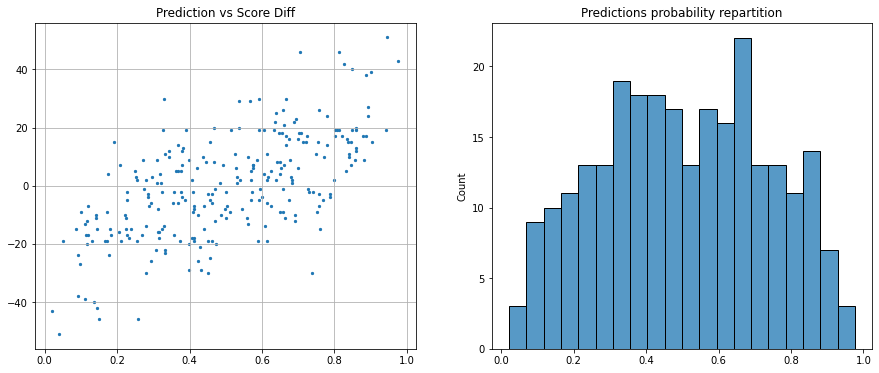

	 -> Scored 0.187

Validating on season 2015


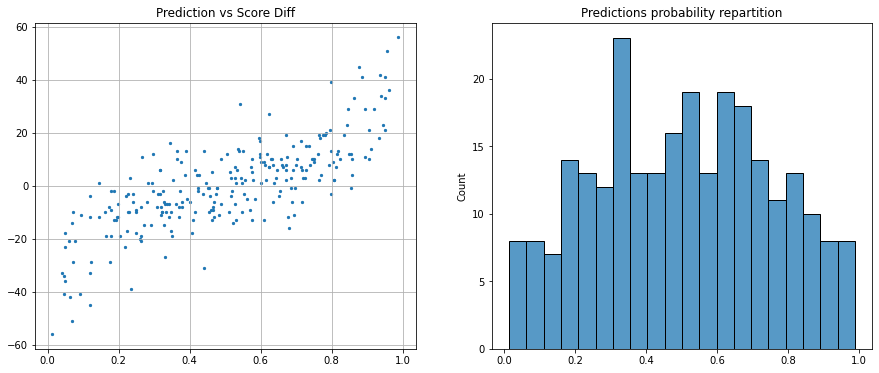

	 -> Scored 0.148

Validating on season 2016


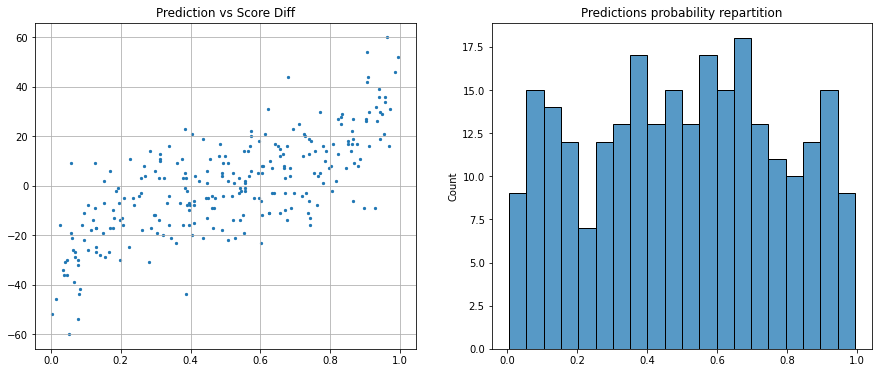

	 -> Scored 0.176

Validating on season 2017


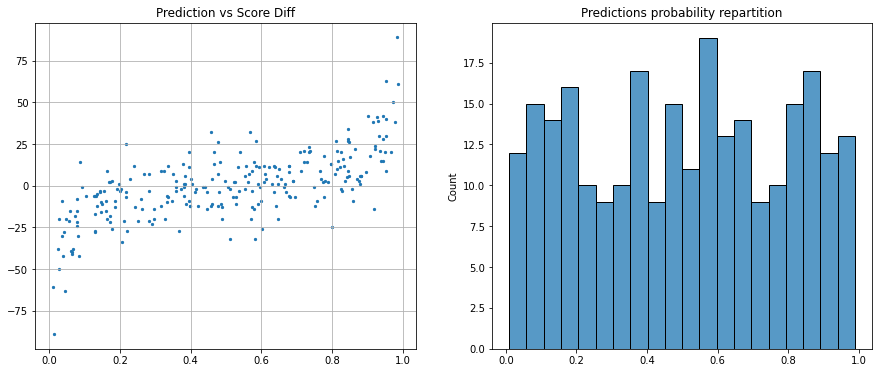

	 -> Scored 0.167

Validating on season 2018


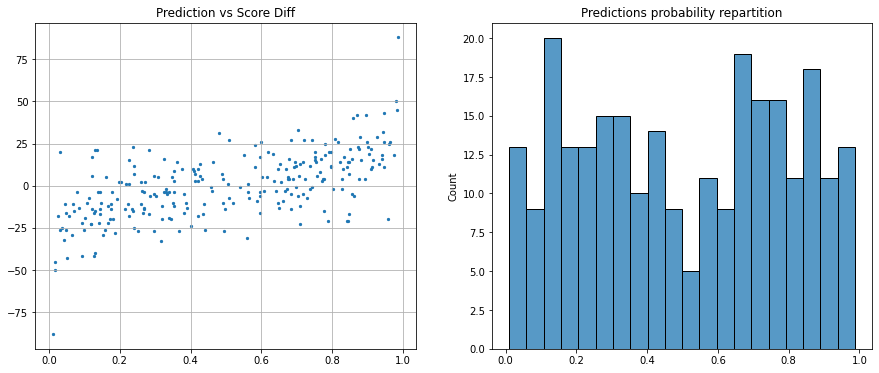

	 -> Scored 0.188

Validating on season 2019


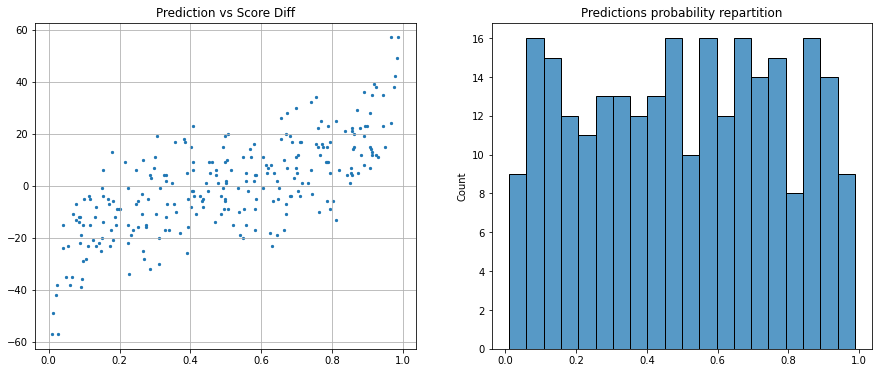

	 -> Scored 0.156

Validating on season 2021


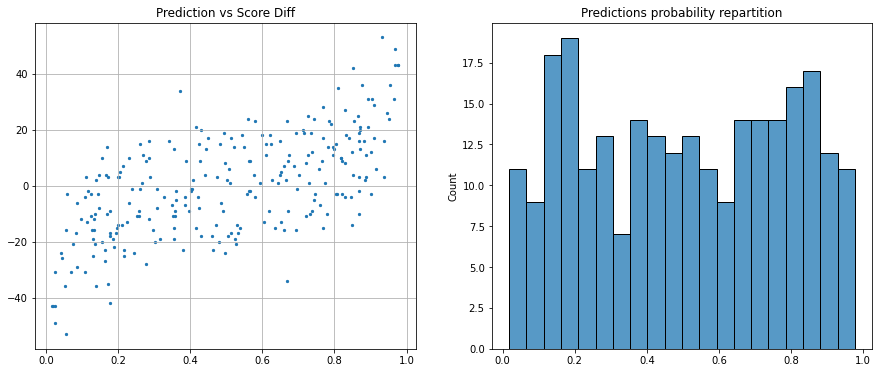

	 -> Scored 0.188

Validating on season 2022


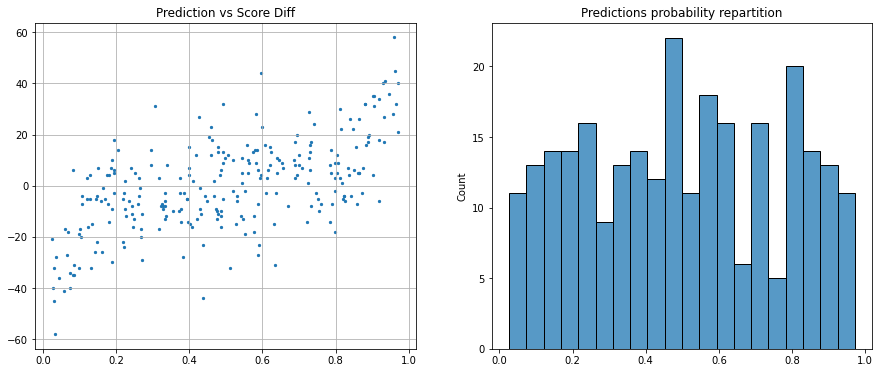

	 -> Scored 0.197

 Local CV is 0.176


In [84]:
pred_tests, cvs = kfold(df, df_test, plot=True, verbose=1, mode="cls")

## Submission

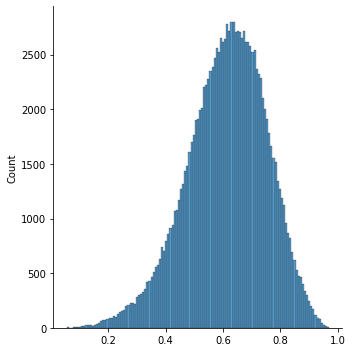

In [85]:
pred_test = np.mean(pred_tests, 0)
df_test['pred'] = pred_test

_ = sns.displot(pred_test)

In [86]:
final_sub = df_test[['ID', 'pred']].copy()
final_sub.to_csv('submission.csv', index=False)

In [87]:
final_sub

,ID,pred
0,2023_1101_1102,0.74
1,2023_1101_1103,0.65
2,2023_1101_1104,0.61
3,2023_1101_1105,0.76
4,2023_1101_1106,0.83
...,...,...
130678,2023_3474_3476,0.56
130679,2023_3474_3477,0.52
130680,2023_3475_3476,0.75
130681,2023_3475_3477,0.72


Done ! 

# AutoML

여기서부터가 가져온 게 아니라 실제로 만든 것, AutoML로 모델 구축

In [1]:
!pip install --use-deprecated=legacy-resolver pycaret[full]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.2/320.2 KB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.7/147.7 KB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 62.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 662.4/662.4 KB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 48.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 41.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 KB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 KB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 19

In [2]:
!pip install numba==0.53

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 37.1 MB/s eta 0:00:00
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.37.0
    Uninstalling llvmlite-0.37.0:
      Successfully uninstalled llvmlite-0.37.0
  Attempting uninstall: numba
    Found existing installation: numba 0.54.1
    Uninstalling numba-0.54.1:
      Successfully uninstalled numba-0.54.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
explainerdashboard 0.4.2.1 requires graphviz>=0.18.2, but you have graphviz 0.10.1 which is incompatible.
explainerdashboard 0.4.2.1 requires scikit-learn>=1.1, but you have scikit-learn 0.23.2 which is incompatible.


In [3]:
!pip uninstall sklearn -y
!pip install --upgrade sklearn
!pip install scikit-learn==0.2 --user

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=ceca8c1bec53f6a75a4414dfc0a67c94d6a3785ca71be9c7b8db1191fa799fb3
  Stored in directory: /root/.cache/pip/wheels/14/25/f7/1cc0956978ae479e75140219088deb7a36f60459df242b1a72
Successfully built sklearn
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement scikit-learn==0.2 (from versions: 0.9, 0.10, 0.11, 0.12, 0.12.1, 0.13, 0.13.1, 0.14, 0.14.1, 0.15.0, 0.15.1, 0.15.2, 0.16.0, 0.16.1, 0.17, 0.17.1, 0.18, 0.18.1, 0.18.2, 0.19.0, 0.19.1, 0.19.2, 0.20.0, 0.20.1, 0.20.2, 0.20.3, 0.20.4, 0.21.1, 0.21.2, 0.21.3, 0.22, 0.22.1, 0.22.2, 0.22.2.post1, 0.23.0, 0.23.1, 0.23.2, 0.24.0, 0.24.1, 0.24.2, 1.0, 1.0.1, 1.0.2, 1.1.0, 1.1.1, 1.1.2, 1.1.3, 1.2.0rc1, 1.2.0, 1.2.

#### Setup

In [88]:
train_df = pd.concat([df[features], df['WinA']],axis=1)

test_df = df_test[features]

In [92]:
#Lucky이 상관계수는 낮은데 막상 모델에서 중요도가 좋게 나올때가 존재했음

train_df.corr()['WinA'].sort_values()

SeedDiff              -0.52
SeedA                 -0.42
AdjDDiff              -0.24
TOmarginDiff          -0.14
LuckyDiff             -0.01
FTDiff                 0.09
FG3Diff                0.18
WinRatioA              0.24
GapAvgA                0.29
FGDiff                 0.33
WinRatioDiff           0.33
AdjODiff               0.37
WinRatio_3yearsDiff    0.39
AdjEMDiff              0.41
GapAvgDiff             0.42
GapAvg_3yearsDiff      0.43
WinA                   1.00
Name: WinA, dtype: float64

오류 생기면 런타임 재시작

In [93]:
#https://pycaret.readthedocs.io/en/latest/api/regression.html

from pycaret.classification import *

pd.options.display.float_format = None

reg_test_1 = setup(data=train_df,   # df 설정
                   target='WinA', # Target 설정
                   train_size= 0.7, # size 설정
                   fold=10,
                   normalize = True,
                   transformation = False,
                   pca = False,
                   feature_selection = False,
                   #remove_outliers = True,
                   #use_gpu = True,
                   #ordinal_features = {'key' : [i for i in range(12)]}'# Fold 설정
                   )


,Description,Value
0,session_id,4629
1,Target,WinA
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(2346, 17)"
5,Missing Values,False
6,Numeric Features,15
7,Categorical Features,1
8,Ordinal Features,False
9,High Cardinality Features,False


INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[], target='WinA',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_strateg...
                                                  target='WinA')),
                ('P_transform', 'passthrough'), ('binn', 'passthrough'),
                ('rem_outliers', '

In [94]:
#logloss 적용 및 predict_proba로 제출하기 위해 metric 추가
add_metric('logloss', 'LogLoss', log_loss, greater_is_better=False, target="pred_proba")

from sklearn.metrics import brier_score_loss

add_metric('Brier', 'Brier', brier_score_loss, greater_is_better=False, target="pred_proba")

Name                                                             Brier
Display Name                                                     Brier
Score Function           <function brier_score_loss at 0x7f7b5d59f0d0>
Scorer               make_scorer(brier_score_loss, greater_is_bette...
Target                                                      pred_proba
Args                                                                {}
Greater is Better                                                False
Multiclass                                                        True
Custom                                                            True
Name: Brier, dtype: object

### Blended Model

In [95]:
#Brier score가 높은 모델 3개를 앙상블 (제외된 2개의 모델은 Brier score를 구할 수 없어서 제외함)

custom_model = compare_models(fold = 10, 
                              sort = 'Brier', 
                              n_select = 3, 
                              exclude=['svm','ridge'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss,Brier,TT (Sec)
lr,Logistic Regression,0.7162,0.8122,0.7126,0.7139,0.7123,0.4323,0.4334,0.5209,0.1771,0.798
lda,Linear Discriminant Analysis,0.7199,0.8105,0.7188,0.7159,0.7167,0.4396,0.4404,0.5245,0.1782,0.069
et,Extra Trees Classifier,0.7187,0.8003,0.7101,0.7197,0.7143,0.4372,0.4379,0.5354,0.1820,0.500
gbc,Gradient Boosting Classifier,0.7223,0.7984,0.7114,0.7228,0.7166,0.4443,0.4449,0.5422,0.1833,1.050
catboost,CatBoost Classifier,0.7052,0.7970,0.6880,0.7090,0.6977,0.4102,0.4110,0.5430,0.1846,8.935
rf,Random Forest Classifier,0.7113,0.7888,0.6769,0.7245,0.6980,0.4222,0.4249,0.5492,0.1872,0.400
lightgbm,Light Gradient Boosting Machine,0.6845,0.7784,0.6732,0.6852,0.6781,0.3689,0.3699,0.6277,0.2065,0.697
knn,K Neighbors Classifier,0.6736,0.7419,0.6682,0.6727,0.6688,0.3470,0.3487,1.4867,0.2123,0.054
xgboost,Extreme Gradient Boosting,0.7059,0.7744,0.6867,0.7096,0.6973,0.4114,0.4123,0.7231,0.2196,1.246
ada,Ada Boost Classifier,0.6833,0.7763,0.6744,0.6822,0.6773,0.3664,0.3674,0.6564,0.2329,0.198


INFO:logs:create_model_container: 14
INFO:logs:master_model_container: 14
INFO:logs:display_container: 2
INFO:logs:[LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=4629, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False), LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001), ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimat

In [96]:
# 가장 좋은 모델에 대해 튜닝

tuned_top = [tune_model(i, optimize = 'Brier') for i in custom_model]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss,Brier
Fold,,,,,,,,,
0,0.6545,0.7734,0.7037,0.6333,0.6667,0.3102,0.3121,0.5600,0.1943
1,0.7697,0.8407,0.7805,0.7619,0.7711,0.5394,0.5396,0.4964,0.1658
2,0.7256,0.8023,0.6914,0.7368,0.7134,0.4507,0.4516,0.5346,0.1799
3,0.6951,0.7752,0.6914,0.6914,0.6914,0.3902,0.3902,0.5606,0.1924
4,0.7561,0.8437,0.7654,0.7470,0.7561,0.5123,0.5124,0.4880,0.1628
5,0.6951,0.8044,0.6173,0.7246,0.6667,0.3891,0.3933,0.5273,0.1795
6,0.6585,0.7416,0.7037,0.6404,0.6706,0.3178,0.3193,0.5948,0.2060
7,0.7195,0.8404,0.7037,0.7215,0.7125,0.4388,0.4389,0.4904,0.1656
8,0.7378,0.8358,0.7037,0.7500,0.7261,0.4751,0.4760,0.4962,0.1665


INFO:logs:create_model_container: 17
INFO:logs:master_model_container: 17
INFO:logs:display_container: 5
INFO:logs:ExtraTreesClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                     criterion='gini', max_depth=11, max_features=1.0,
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0, min_impurity_split=None,
                     min_samples_leaf=3, min_samples_split=9,
                     min_weight_fraction_leaf=0.0, n_estimators=130, n_jobs=-1,
                     oob_score=False, random_state=4629, verbose=0,
                     warm_start=False)
INFO:logs:tune_model() succesfully completed......................................


In [97]:
# Brier score

blended_custom = blend_models(estimator_list = tuned_top,
                              fold = 10,
                              optimize = 'Brier')

pred_holdout_custom = predict_model(blended_custom)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss,Brier
Fold,,,,,,,,,
0,0.6788,0.7726,0.6790,0.6707,0.6748,0.3575,0.3575,0.5601,0.1953
1,0.7394,0.8443,0.7439,0.7349,0.7394,0.4788,0.4788,0.4891,0.1623
2,0.7134,0.8136,0.6667,0.7297,0.6968,0.4261,0.4277,0.5193,0.1756
3,0.7012,0.7916,0.7037,0.6951,0.6994,0.4024,0.4025,0.5456,0.1857
4,0.7561,0.8416,0.7654,0.7470,0.7561,0.5123,0.5124,0.4829,0.1615
5,0.7012,0.8025,0.6667,0.7105,0.6879,0.4019,0.4027,0.5327,0.1819
6,0.6890,0.7662,0.7407,0.6667,0.7018,0.3788,0.3811,0.5723,0.1979
7,0.7256,0.8388,0.7284,0.7195,0.7239,0.4512,0.4513,0.4935,0.1668
8,0.7317,0.8516,0.6914,0.7467,0.7179,0.4629,0.4641,0.4783,0.1604


INFO:logs:create_model_container: 18
INFO:logs:master_model_container: 18
INFO:logs:display_container: 6
INFO:logs:VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=0.356, class_weight={},
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=1000,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=4629,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('lda',
                              LinearDiscriminantAnalysis(n_components=None,
                                                         prio

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss,Brier
0,Voting Classifier,0.7514,0.8291,0.7597,0.7576,0.7586,0.5024,0.5024,0.5057,0.1688


In [98]:
#최종 모델
final_model_custom = finalize_model(blended_custom)

INFO:logs:Initializing finalize_model()
INFO:logs:finalize_model(estimator=VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=0.356, class_weight={},
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=1000,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=4629,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('lda',
                              LinearDiscriminantAnalysis(n_components=None,
                                                         priors=None,
                               

In [99]:
#
prep_pipe = get_config("prep_pipe")

prep_pipe.steps.append(['trained_model', final_model_custom])

predictions = predict_model(prep_pipe,
                            data=test_df,
                            raw_score=True)

INFO:logs:Initializing get_config()
INFO:logs:get_config(variable=prep_pipe)
INFO:logs:Global variable: prep_pipe returned as Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[], target='WinA',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_strateg...
                                                  target='WinA')),
                ('P_transform', 'passthrough'), ('binn', 'passthrough'),
                ('rem

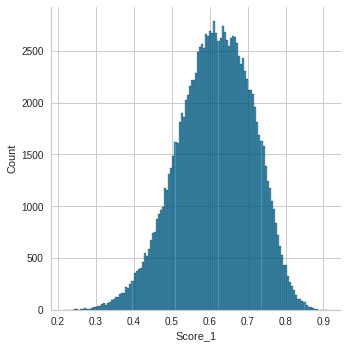

In [100]:
df_test_after_AutoML = df_test.copy()

df_test_after_AutoML['pred'] = predictions['Score_1']

_ = sns.displot(predictions['Score_1'])

#### 최종 제출 파일

In [108]:
final_sub_after_AutoML = df_test_after_AutoML[['ID', 'pred']].copy()

final_sub_after_AutoML.to_csv('submission_0304.csv', index=False)

In [102]:
final_sub_after_AutoML

,ID,pred
0,2023_1101_1102,0.7263
1,2023_1101_1103,0.6726
2,2023_1101_1104,0.6564
3,2023_1101_1105,0.7286
4,2023_1101_1106,0.7633
...,...,...
130678,2023_3474_3476,0.5070
130679,2023_3474_3477,0.5723
130680,2023_3475_3476,0.6907
130681,2023_3475_3477,0.6755


### Test : 2022년도로 Test

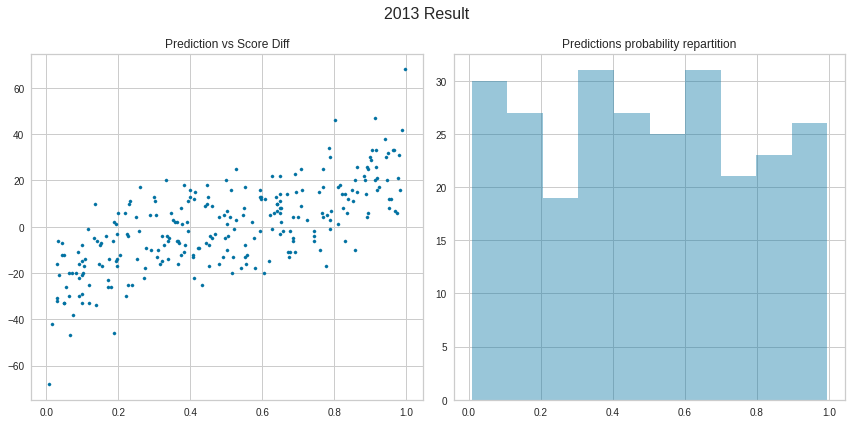

2013 Score :  0.16404230730834865


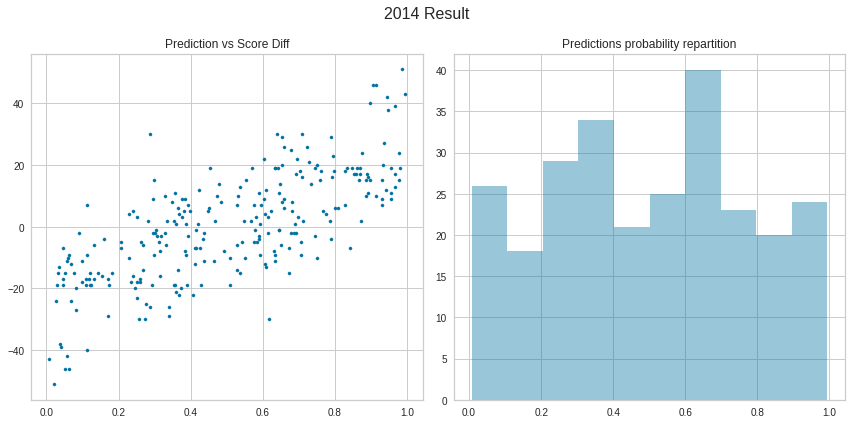

2014 Score :  0.15556774258381606


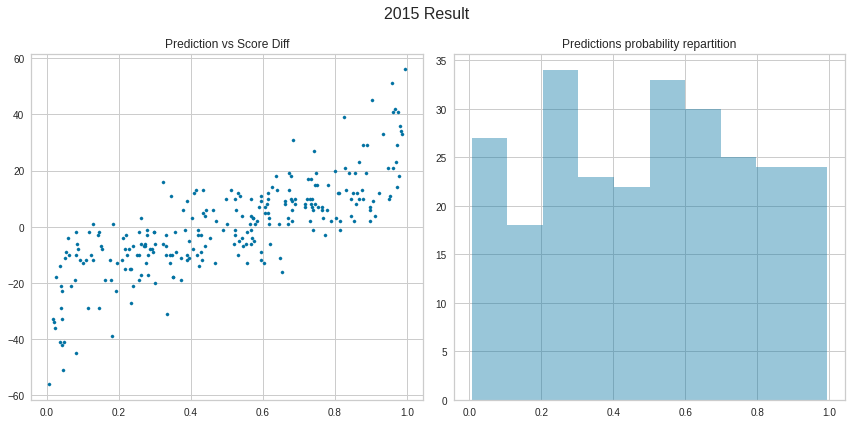

2015 Score :  0.11995689860235124


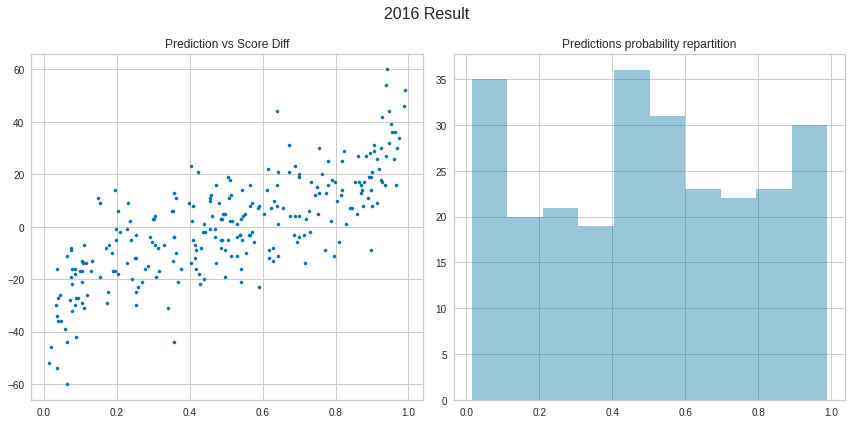

2016 Score :  0.1503649577002875


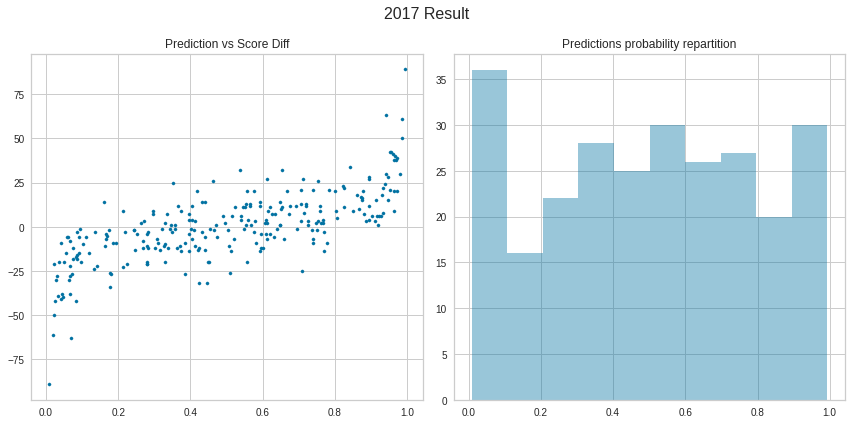

2017 Score :  0.13923951209763225


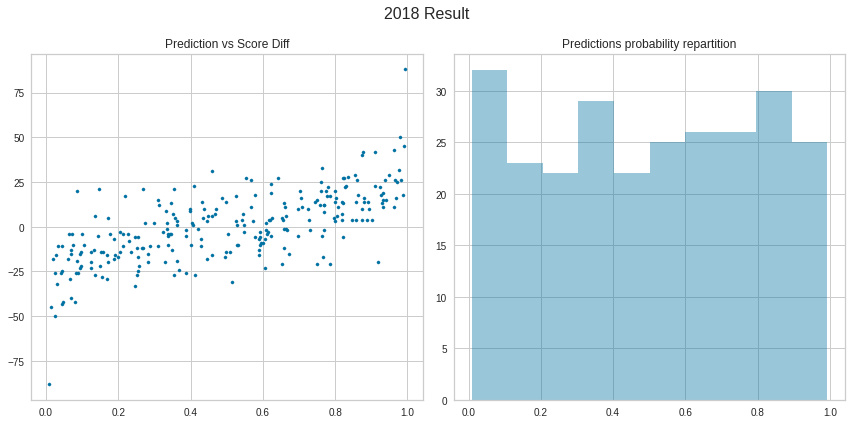

2018 Score :  0.15814636955033728


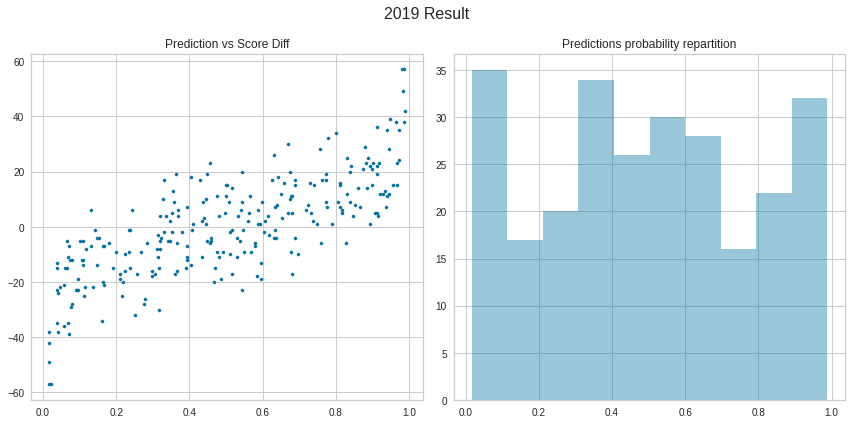

2019 Score :  0.1324269056783239


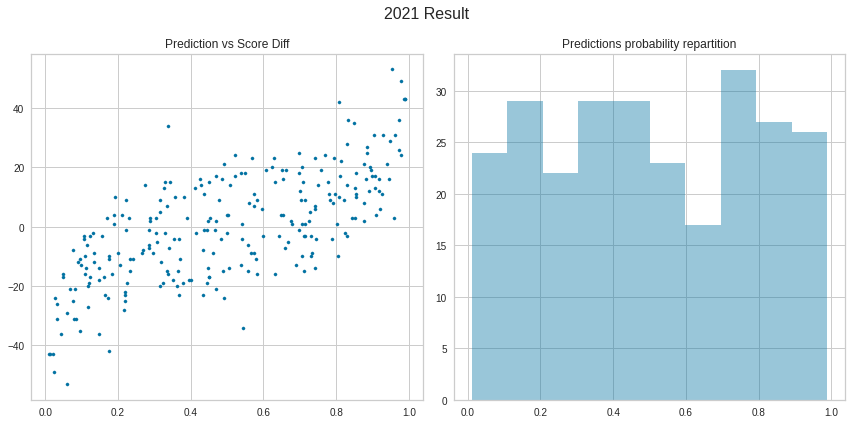

2021 Score :  0.1615819904873424


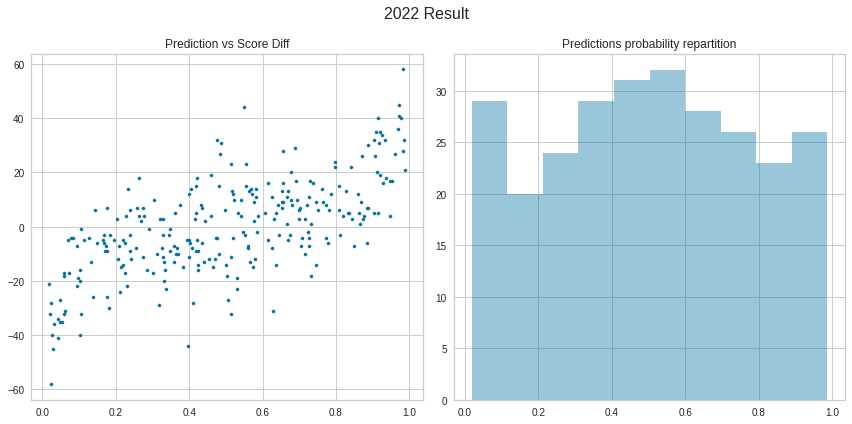

2022 Score :  0.16581877786998198


In [130]:
for year in df['Season'].unique():

  df_val = df[df['Season'] == year]

  df_val = df_val.reset_index(drop=True)

  prediction = prep_pipe.predict_proba(df_val[features])

  i, j = [], []
  for row in prediction:
    i.append(row[0])
    j.append(row[1])

  len(i), len(j)

  df_val['pred'] = j

  df_val['WinA_pred'] = prep_pipe.predict(df_val[features])
  
  #plt.figure(figsize=(12, 6))
  fig, ax = plt.subplots(1, 2,figsize = [12, 6])

  ax[0].scatter(df_val['pred'], df_val['ScoreDiff'].values, s=10)
  ax[0].set_title('Prediction vs Score Diff')

  ax[1].hist(df_val['pred'], bins = 10, alpha = 0.4)
  ax[1].set_title('Predictions probability repartition')

  fig.suptitle(f'{year} Result', fontsize=16) # figure 제목

  fig.tight_layout() # 사용하면 플롯간 여백을 조정해준다. 
  plt.show()
  
  print(f'{year} Score : ', brier_score_loss(df_val['WinA'], df_val['pred']))

In [131]:
# 2022년 대상으로 할 시 약 0.188 정도 나옴옴

brier_score_loss(df_val['WinA'], df_val['pred'])

0.16581877786998198

In [133]:
# 모델 저장장
save_model(model=prep_pipe, 
           model_name='ModelV1_20230304_0.16',
           verbose=False)

INFO:logs:Initializing save_model()
INFO:logs:save_model(model=Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[], target='WinA',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_strateg...
                                                                    max_features=1.0,
                                                                    max_leaf_nodes=None,
                                                 

(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[], target='WinA',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_strateg...
                                                                     max_features=1.0,
                                                                     max_leaf_nodes=None,
                                                                     max_samples=None,
          

### 아래의 식은 시뮬레이션을 통해 적절히 확률을 변경하는 경우이나 좋은 성적은 거두지 못했음

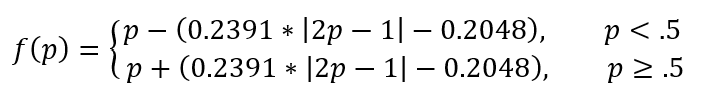

In [ ]:
# 2022년 대상으로 할 시 약 0.188 정도 나옴옴

df_val.loc[df_val['pred'] < 0.5, 'pred'] = df_val.loc[df_val['pred'] < 0.5, 'pred'] - (0.2391 *abs(2*df_val.loc[df_val['pred'] < 0.5, 'pred'] -1) - 0.2048)

df_val.loc[df_val['pred'] >= 0.5, 'pred'] = df_val.loc[df_val['pred'] >= 0.5, 'pred'] + (0.2391 *abs(2*df_val.loc[df_val['pred'] >= 0.5, 'pred'] -1) - 0.2048)

In [ ]:
# 2022년 대상으로 할 시 약 0.188 정도 나옴옴

brier_score_loss(df_val['WinA'], df_val['pred'])

0.18714202758211013

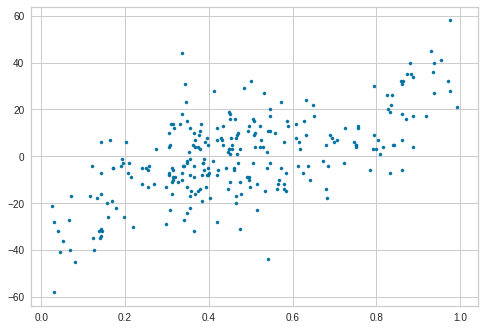

In [ ]:
plt.scatter(df_val['pred'], df_val['ScoreDiff'].values, s=10)

https://www.nbastuffer.com/analytics-101/team-evaluation-metrics/

# Woman / Man 분화

## Man

In [ ]:
train_man = df[df['TeamIdA'].astype('str').str.contains('^1',regex= True)]

train_woman = df[df['TeamIdA'].astype('str').str.contains('^3',regex= True)]

test_man = df_test[df_test['TeamIdA'].astype('str').str.contains('^1',regex= True)]

test_woman = df_test[df_test['TeamIdA'].astype('str').str.contains('^3',regex= True)]

In [ ]:
train_df_man = pd.concat([train_man[features], train_man['WinA']],axis=1)

test_df_man = test_man[features]

In [ ]:
train_df_woman = pd.concat([train_woman[features], train_woman['WinA']],axis=1)

test_df_woman = test_woman[features]

In [ ]:
#https://pycaret.readthedocs.io/en/latest/api/regression.html

from pycaret.classification import *

reg_test_1 = setup(data=train_df_woman,   # df 설정
                   target='WinA', # Target 설정
                   train_size= 0.7, # size 설정
                   fold=5,
                   normalize = True,
                   transformation = False,
                   pca = False,
                   #use_gpu = True,
                   #ordinal_features = {'key' : [i for i in range(12)]}'# Fold 설정
                   )

#logloss 적용 및 predict_proba로 제출하기 위해 metric 추가
add_metric('logloss', 'LogLoss', log_loss, greater_is_better=False, target="pred_proba")

from sklearn.metrics import brier_score_loss

add_metric('Brier', 'Brier', brier_score_loss, greater_is_better=False, target="pred_proba")

,Description,Value
0,session_id,2713
1,Target,WinA
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(2402, 14)"
5,Missing Values,True
6,Numeric Features,13
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[], target='WinA',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_strateg...
                                                  target='WinA')),
                ('P_transform', 'passthrough'), ('binn', 'passthrough'),
                ('rem_outliers', '

Name                                                             Brier
Display Name                                                     Brier
Score Function           <function brier_score_loss at 0x7fc5ed591f70>
Scorer               make_scorer(brier_score_loss, greater_is_bette...
Target                                                      pred_proba
Args                                                                {}
Greater is Better                                                False
Multiclass                                                        True
Custom                                                            True
Name: Brier, dtype: object

In [ ]:
#Brier score가 높은 모델 3개를 앙상블 (제외된 2개의 모델은 Brier score를 구할 수 없어서 제외함)

custom_model = compare_models(fold = 5, 
                              sort = 'Brier', 
                              n_select = 1, 
                              exclude=['svm','ridge'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss,Brier,TT (Sec)
lr,Logistic Regression,0.7971,0.8797,0.7954,0.7962,0.7953,0.5942,0.5950,0.4313,0.1424,1.464
lda,Linear Discriminant Analysis,0.7959,0.8795,0.7906,0.7974,0.7932,0.5918,0.5930,0.4323,0.1428,0.034
catboost,CatBoost Classifier,0.7840,0.8658,0.7882,0.7795,0.7836,0.5681,0.5684,0.4597,0.1520,5.666
et,Extra Trees Classifier,0.7817,0.8573,0.7882,0.7760,0.7820,0.5633,0.5636,0.4709,0.1542,0.536
gbc,Gradient Boosting Classifier,0.7739,0.8612,0.7858,0.7660,0.7753,0.5479,0.5489,0.4642,0.1547,0.412
rf,Random Forest Classifier,0.7823,0.8533,0.7834,0.7798,0.7810,0.5645,0.5653,0.5169,0.1563,0.386
lightgbm,Light Gradient Boosting Machine,0.7573,0.8485,0.7523,0.7574,0.7547,0.5145,0.5147,0.5555,0.1743,0.594
knn,K Neighbors Classifier,0.7371,0.8098,0.7320,0.7370,0.7343,0.4741,0.4744,1.7271,0.1816,0.058
xgboost,Extreme Gradient Boosting,0.7513,0.8429,0.7404,0.7543,0.7468,0.5026,0.5031,0.6128,0.1839,0.612
qda,Quadratic Discriminant Analysis,0.7150,0.8300,0.7226,0.7319,0.7127,0.4302,0.4472,0.5967,0.1917,0.020


INFO:logs:create_model_container: 14
INFO:logs:master_model_container: 14
INFO:logs:display_container: 2
INFO:logs:LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=2713, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
INFO:logs:compare_models() succesfully completed......................................


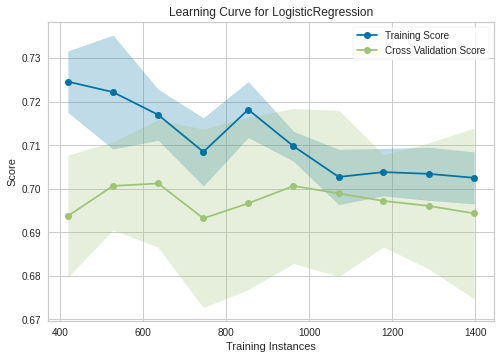

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plot_model(custom_model, plot = 'learning', use_train_data = True)

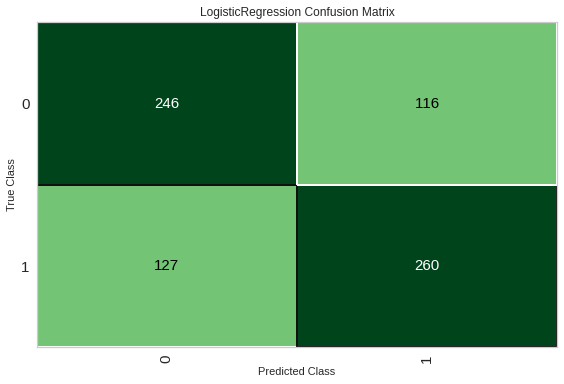

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plot_model(custom_model,plot = 'confusion_matrix')

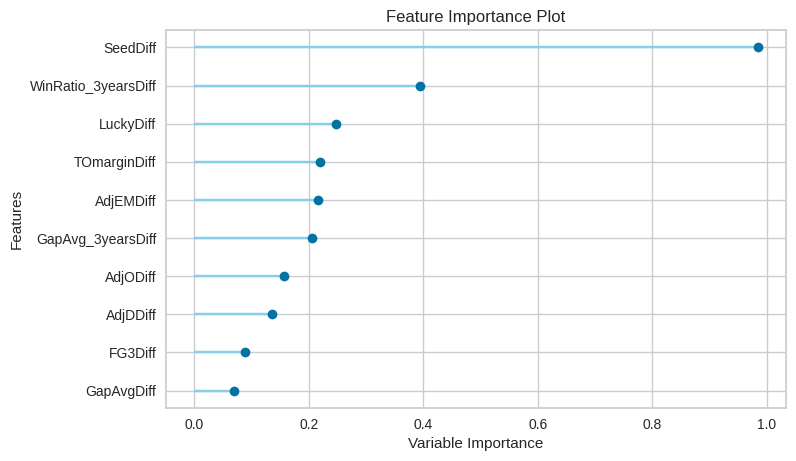

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plot_model(custom_model,plot = 'feature')